In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 

To do: Hamiltonian for H_2 on 8 qubits using 6-31G basis.
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from functools import partial

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from collections import Counter

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

from modified_derandomization import modified_derandomized_classical_shadow





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86



# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Use classical eigensolver to obtain the ground state energy for the molecule of interest. 
This value is ca. -1.86 and will be used for evaluating the accuracy of the results found by the quantum-classical method.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy found using classical eigensolver:\n', res) 

/tmp/ipykernel_280/690678606.py:6: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(BravyiKitaevMapper())


Electronic ground state energy found using classical eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties. 
This includes removing all Pauli-I operators.
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print('All Hamiltonian terms:\n', hamiltonian_terms)
print('All weights:\n', weights)




hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

weights_XYZ = weights.copy()
weights_XYZ.pop(0)

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZE)
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)
print('Absolute weights:\n', abs_weights)
print('Weights with proper signs:\n', weights_XYZ)

All Hamiltonian terms:
 [[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
All weights:
 [-0.8105479805373264, 0.17218393261915543, -0.22575349222402474, 0.1209126326177664, 0.1721839326191556, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, -0.22575349222402485, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms

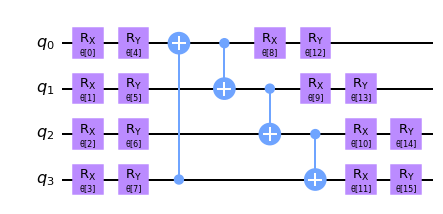

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [4]:
'''
Define the cost function = the expectation value of the Hamiltonian H. 
Since the Hamiltonian is processed term by term, the expectation value is composed as follows:
expval(H) = sum_i (weight_i * expval(term_i))
'''


backend = QasmSimulator(method='statevector', shots=1)


# generate a circuit with just a single layer of randomised basis change operators
# this circuit is appended to the ansatz and then measurements are taken in the Pauli-Z basis
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.h(idx)
        elif op == 'Y':
            rand_meas.h(idx)
            rand_meas.p(-np.pi/2, idx)
        elif op == 'Z':
            rand_meas.id(idx)
    return rand_meas



def objective_function(operators, params):
    
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    # NOTE: For term = [] we have that sum_product = match_count = len(shadow)
    
    cost = 0.0

    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)     
        
    cost_history.append(cost)

        
    return cost


NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

1 | Counter({('X', 'X', 'X', 'X'): 1}) | 1.0042192195166189
250 | Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4}) | 0.40459657636328894
500 | Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 8, ('Z', 'X', 'Z', 'X'): 1}) | 0.5177116749665187
750 | Counter({('X', 'X', 'X', 'X'): 736, ('Z', 'Z', 'Z', 'Z'): 12, ('Z', 'X', 'Z', 'X'): 2}) | 0.5699420333211132
1000 | Counter({('X', 'X', 'X', 'X'): 981, ('Z', 'Z', 'Z', 'Z'): 16, ('Z', 'X', 'Z', 'X'): 3}) | 0.6647976668836281
1250 | Counter({('X', 'X', 'X', 'X'): 1225, ('Z', 'Z', 'Z', 'Z'): 19, ('Z', 'X', 'Z', 'X'): 4, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1}) | 0.6266566076349679
1500 | Counter({('X', 'X', 'X', 'X'): 1471, ('Z', 'Z', 'Z', 'Z'): 23, ('Z', 'X', 'Z', 'X'): 4, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1}) | 0.7011365963911774
1750 | Counter({('X', 'X', 'X', 'X'): 1716, ('Z', 'Z', 'Z', 'Z'): 27, ('Z', 'X', 'Z', 'X'): 5, ('Z', 'X'

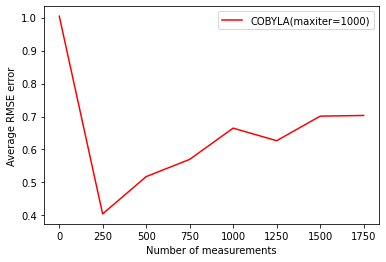

In [6]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Here we are using COBYLA optimizer, which is NOT a gradient descent optimizer. 
'''



start_time = time.time()
rmse_errors = []


measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]
print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    

    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        #print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='COBYLA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

1 | Counter({('X', 'X', 'X', 'X'): 1}) | 1.0042192195166189
250 | Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4}) | 0.019393181390233882
500 | Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 8, ('Z', 'X', 'Z', 'X'): 1}) | 0.19002711808259357
750 | Counter({('X', 'X', 'X', 'X'): 736, ('Z', 'Z', 'Z', 'Z'): 12, ('Z', 'X', 'Z', 'X'): 2}) | 0.10267963956224503
1000 | Counter({('X', 'X', 'X', 'X'): 981, ('Z', 'Z', 'Z', 'Z'): 16, ('Z', 'X', 'Z', 'X'): 3}) | 0.29243712582499987
1250 | Counter({('X', 'X', 'X', 'X'): 1225, ('Z', 'Z', 'Z', 'Z'): 19, ('Z', 'X', 'Z', 'X'): 4, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1}) | 0.21602285627572904
1500 | Counter({('X', 'X', 'X', 'X'): 1471, ('Z', 'Z', 'Z', 'Z'): 23, ('Z', 'X', 'Z', 'X'): 4, ('Z', 'X', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X'): 1}) | 0.20790934359124869
1750 | Counter({('X', 'X', 'X', 'X'): 1716, ('Z', 'Z', 'Z', 'Z'): 27, ('Z', 'X', 'Z', 'X'): 5, ('Z

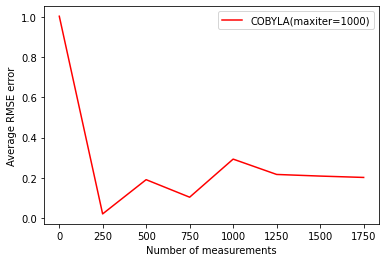

In [12]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Here we are using SPSA optimizer, which approximates gradient descent. Maxiter = 1000.
'''



start_time = time.time()
rmse_errors = []


measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]
print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    

    optimizer = SPSA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        #print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [13]:
start_time = time.time()

measurement_range = [1000]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))




NUMBER OF OPERATORS: 1000
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 981, ('Z', 'Z', 'Z', 'Z'): 16, ('Z', 'X', 'Z', 'X'): 3})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.4348986939124655
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.724688892283477
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.6763093478440374
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8497471765535958
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.840553518027974
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.6143005826648293
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.8011642627649598
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.840553518027974
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.7635075496401011
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.8402777082722055
AVERAGE RMSE ERROR: 0.17525796219612103
Execution time =  00:36:05


In [ ]:
'''
Rerunning for num_operators = 1000 with SPSA(maxiter=2000) but this time we pass the weights with both + and - signs
'''


start_time = time.time()


measurement_range = [1000]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=weights_XYZ)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS: 1000
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 985, ('Z', 'Z', 'Z', 'Z'): 11, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.9439151781199768


NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 247, ('Z', 'Z', 'Z', 'Z'): 2, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.966765343356276
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.9840060610178383
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.9605389660357662
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.9579751636096736
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.9674978583351597
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.9854710909756053
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.980683127955063
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.9700882764190513
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.9620306116513326
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.9675244739929592
AVERAGE RMSE ERROR: 0.11065168164272253
NUMBER OF OPERATORS: 500
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 493, ('Z', 'Z', 'Z', 'Z'): 5, ('Z', 'X', 'Z', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -2.

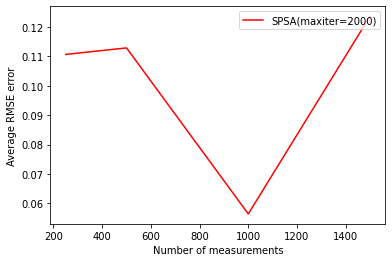

In [6]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 

'''



start_time = time.time()

rmse_errors = []
measurement_range = [250, 500, 1000, 1500]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=weights_XYZ)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

NUMBER OF OPERATORS: 10
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 9, ('Z', 'Z', 'Z', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.872149057827696
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8822007911490422
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8822007911490422
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.872149057827696
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.8822007911490422
AVERAGE RMSE ERROR: 0.018835204247002746
NUMBER OF OPERATORS: 50
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 49, ('Z', 'Z', 'Z', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8766620809515657
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8655846605566129
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8803545544165503
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8655846605566129
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.869277134021597
AVERAGE RMSE ERROR: 0.012964373566452593
NUMBER OF OPERATORS: 200
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 199,

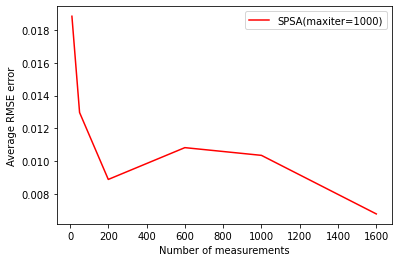

In [8]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Modified derandomization involves adding num_operators to be generated and changing 2 places in the original code:
1. 'for repetition in range(num_operators)' instead of range(num_evals * len(all_observables))
2. 'if success == len(all_observables) and len(measurement_procedure) == num_operators' instead of 
'if success == len(all_observables)'
'''



start_time = time.time()

rmse_errors = []
num_evals = 10
measurement_range = [10, 50, 200, 600, 1000, 1600]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, num_evals, system_size, weight=weights_XYZ)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=1000)  
    cost_function = partial(objective_function, derandomized_hamiltonian)
    expectation_values = []
    num_experiments = 5


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

NUMBER OF OPERATORS: 10
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 10})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -0.8557807804833842
AVERAGE RMSE ERROR: 1.004219219516616
NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8450584107055314
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8450584107055314
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.843587425341432
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8377034838850344
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.8502068594798795
AVERAGE RMSE ERROR: 0.016179709640929834
NUMBER OF OPERATORS: 500
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 

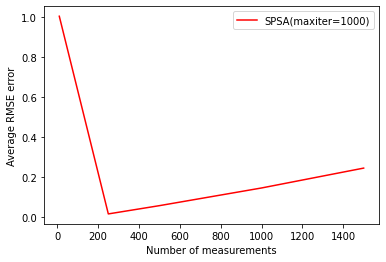

In [5]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Modified derandomization involves adding num_operators to be generated and changing 2 places in the original code:
1. 'for repetition in range(num_operators)' instead of range(num_evals * len(all_observables))
2. 'if success == len(all_observables) and len(measurement_procedure) == num_operators' instead of 
'if success == len(all_observables)'
'''



start_time = time.time()

rmse_errors = []
measurement_range = [10, 250, 500, 1000, 1500]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=1000)  
    cost_function = partial(objective_function, derandomized_hamiltonian)
    expectation_values = []
    num_experiments = 5


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

NUMBER OF OPERATORS: 10
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 10})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -0.8557807804833842
AVERAGE RMSE ERROR: 1.004219219516616
NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8450584107055314
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8472648887516805
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8498391131388547
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.841380947295283
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.8494713667978295
AVERAGE RMSE ERROR: 0.013756445846827867
NUMBER OF OPERATORS: 500
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 

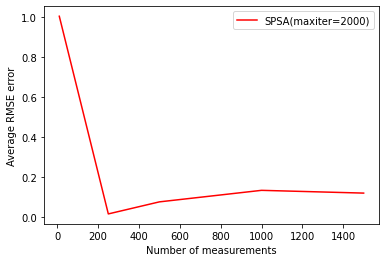

In [6]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Modified derandomization involves adding num_operators to be generated and changing 2 places in the original code:
1. 'for repetition in range(num_operators)' instead of range(num_evals * len(all_observables))
2. 'if success == len(all_observables) and len(measurement_procedure) == num_operators' instead of 
'if success == len(all_observables)'
'''



start_time = time.time()

rmse_errors = []
measurement_range = [10, 250, 500, 1000, 1500]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)  
    cost_function = partial(objective_function, derandomized_hamiltonian)
    expectation_values = []
    num_experiments = 5


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)